# Evaluating sea ice segmentation

The purpose of the TGRS paper is to describe an approach to evaluating sea ice segmentation drawing on the methods of geographic object-based image analysis (GEOBIA) and traditional segmentation analysis. 

## Goals of image segmentation for sea ice floe identification
The aim of the segmentation is to identify distinct sea ice floes from a scene that may contain multiple heterogeneous ice types, water and land surfaces, and clouds. The resulting objects should have boundaries that match the physical boundary of the ice floe. The physical measurements of the ice floe, including the size, location (centroid), and shape (boundary) are of scientific interest. For example, the momentum exchange between the wind, ice, and ocean depends on the distribution of floe sizes in a scene. Sea ice models use estimates of the floe size distribution properties to parameterize air-ice-ocean coupling. Accurate estimation of the ice floe areas for a representative sample of ice floes is thus important for sea ice model development. Similarly, observational studies of sea ice dynamics, including tracking the dispersion, transport, and evolution of sea ice, rely on measurements of changes in position of individual pieces of ice. Algorithmic approaches to ice floe tracking can use properties of the ice floe size and shape to identify individual ice floes across multiple images. Thus evaluation for sea ice segmentation performance should assess:

- fraction of available floes identified
- skill at locating the correct position of the floe
- skill at identifying the floe boundary
- skill at identifying the floe area

In addition, it is useful to document the contribution of oversegmentation and undersegmentation errors. Both OSE and USE will decrease skill in physical measurements of the objects. 

## Literature review
### Domain-agnostic segmentation evaluation metrics
1. Pixel-wise segmentation evaluation. These methods are simple to apply and are usually based on the confusion matrix. All pixels are assigned a class and thus can be TP, FP, TN, or FN.
2. Object-wise segmentation evaluation. (AKA Object Based Image Analysis (OBIA). In this paradigm, groups of pixels are compared comprising objects, rather than considered individually.
   - Supervised evaluation -- Identifying which objects to compare
   - Unsupervised evaluation -- Examine properties of the object itself







In [1]:
import os
import pandas as pd
import skimage
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import proplot as pplt

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading images
The code below loads all the true color and manually labeled images into dictionaries.

TBD: Save the segmented images in a format that can be read in here. GeoTiff labeled images would be ideal.

In [2]:
# Load case data
df = pd.concat([pd.read_csv('../data/validation_tables/' + f) for f in os.listdir('../data/validation_tables/') if '.csv' in f])
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        return  '-'.join([cn, region, date, sat, 'labeled_floes.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction']:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])
        
# Load images
tc_dataloc = '../data/modis/truecolor/'
cl_dataloc = '../data/modis/cloudfraction/'
lb_dataloc = '../data/validation_images/labeled_floes_png/'
landmask_dataloc = '../data/validation_images/landmask_png/'
landfast_dataloc = '../data/validation_images/labeled_landfast_png/'
ift_lb_dataloc = '../data/segmented_images/ift_default_labeled_floes/'

tc_images = {}
cl_images = {}
lb_images = {}
ift_lb_images = {}
landmasks = {}
landfast_images = {}

missing = []
for row, data in df.iterrows():
    
    for dataloc, imtype, data_dict in zip([tc_dataloc, cl_dataloc],
                                          ['truecolor', 'cloudfraction'],
                                          [tc_images, cl_images]):
        try:
            with rio.open(dataloc + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))

    if data.visible_floes != 'no':
        try:
            with rio.open(lb_dataloc + fname(df.loc[row,:], 'labeled')) as im:
                lb_images[row] = im.read()
        except:
            # print('Couldn\'t read', fname(df.loc[row,:], 'labeled'))
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))        
        try:
            with rio.open(ift_lb_dataloc + fname(df.loc[row,:], 'labeled').replace('png', 'tiff')) as im:
                ift_lb_images[row] = im.read()
        except:
            pass
    try:
        with rio.open(landmask_dataloc + fname(df.loc[row,:], 'labeled').replace('labeled_floes', 'landmask')) as im:
            landmasks[row] = im.read()
    except:
        pass            
    try:
        with rio.open(landfast_dataloc + fname(df.loc[row,:], 'labeled').replace('labeled_floes', 'labeled_landfast')) as im:
            landfast_images[row] = im.read()
    except:
        pass                    

FileNotFoundError: [Errno 2] No such file or directory: '../data/validation_tables/'

In [43]:
fname(df.loc[row,:], 'labeled')

'441-baffin_bay-20200726-terra-labeled_floes.png'

In [235]:
processed = list(ift_lb_images.keys())
processed.sort()
processed

['016_aqua',
 '016_terra',
 '022_aqua',
 '022_terra',
 '023_aqua',
 '023_terra',
 '032_aqua',
 '032_terra',
 '081_terra',
 '108_terra',
 '110_aqua',
 '110_terra',
 '119_aqua',
 '119_terra',
 '122_aqua',
 '122_terra',
 '132_aqua',
 '142_aqua',
 '142_terra',
 '145_aqua',
 '146_aqua',
 '146_terra',
 '229_aqua',
 '229_terra',
 '283_aqua',
 '283_terra',
 '298_aqua',
 '298_terra',
 '301_terra',
 '302_aqua',
 '302_terra',
 '324_aqua',
 '324_terra',
 '325_aqua',
 '325_terra',
 '329_aqua',
 '329_terra',
 '339_aqua',
 '339_terra',
 '340_terra',
 '372_terra',
 '385_terra',
 '433_aqua',
 '447_aqua',
 '447_terra',
 '454_aqua',
 '454_terra']

In [236]:
for case in processed:
    
    fig, ax = pplt.subplots(nrows=1, ncols=2, width=7)
    ax[0].imshow(reshape_as_image(tc_images[case]))
    if case in lb_images:
        manual_floe_labels = np.ma.masked_array(lb_images[case][0,:,:], mask=lb_images[case][0,:,:]==0)
        ax[0].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
        ax[1].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
    if case in ift_lb_images:
        ift_floe_labels = np.ma.masked_array(ift_lb_images[case][0,:,:], mask=ift_lb_images[case][0,:,:]==0)
        ax[0].pcolormesh(ift_floe_labels, color='r', alpha=0.5)        
        ax[1].pcolormesh(ift_floe_labels, color='r', alpha=0.5)

    try:
        landmask = np.ma.masked_array(landmasks[case][0,:,:], mask=landmasks[case][0,:,:]==0)
        landfast = np.ma.masked_array(landfast_images[case][0,:,:], mask=landfast_images[case][0,:,:]==0)
        if ~np.any(landmask > 0):
            landmask = landmask*0
        
        ax[1].pcolormesh(landmask, color='k', alpha=0.5)
        ax[1].pcolormesh(landfast, color='gold', alpha=0.5)
    except:
        print('Couldn\'t plot landmask/landfast for', case)
    ax.format(yreverse=True, title=case)

    for color, label in zip(['b', 'r', 'k', 'gold'], ['manual', 'ift', 'land', 'landfast']):
        ax[0].plot([],[],m='s', lw=0, color=color, alpha=0.75, label=label)
    fig.legend(loc='b', ncols=2, alpha=0.9)

    fig.save('../figures/../figures/ift_default_lopez-acosta/' + case + '_overlay.png', dpi=300)
    pplt.close(fig)

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/si

Couldn't plot landmask/landfast for 108_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/si

Couldn't plot landmask/landfast for 145_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 229_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 229_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 298_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 298_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/si

Couldn't plot landmask/landfast for 329_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 329_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 372_terra


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 433_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 454_aqua


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Couldn't plot landmask/landfast for 454_terra


# Object-based evaluation

In order to consider the quality of segmented objects against a reference dataset, we need to first be able to link image segments to ground truth, in other words identify true positives. Considering a set of predicted segments $\hat S$ and a ground truth set $S$, we wish to find a map linking $\hat s \in \hat S$ to $s \in S$.

In Simon's code, the primary matching metric is the intersection over union (the Jaccard index). Letting $|A|$ be the area covered by a set $A$, then the intersection over union of $A$ and $B$ is
$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$
This is a reasonable, intuitive measure. Where we ran into an issue is the idea that in the literature (references?) a cutoff of $J(A,B)>0.5$ to count as a true positive. 

For a true floe $s$, we define the set of _candidate objects_ as the set $\hat s \in S$ such that $J(\hat s, s) > 0$. 
_Oversegmentation error_ (OSE) is indicated by the presence of multiple candidate objects. Similarly, _undersegmentation error_ is defined by the opposite relation: a single candidate object in $\hat S$ matching to multiple true floes in $S$.

There are some challenges with $J$ as a metric. Since it depends on the area of shapes, the sensitivity of the metric will vary with floe size. Suppose an object is composed of 4 pixels each with area 1. A segmentation algorithm produces an object that is off by one pixels. The Jaccard index will then be 0.75 if the pixels are maximally aligned. An offset by 1 pixel to the side would produce J=0.3, and 1 down and 1 over would be J=0.14. 

* The minimum object size should depend on the number of pixels, and this minimum should account for the sensitivity of the metric.

The Jaccard index dates to the 19th century, and since then, strengths and weaknesses of the method have been often described in the literature.


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


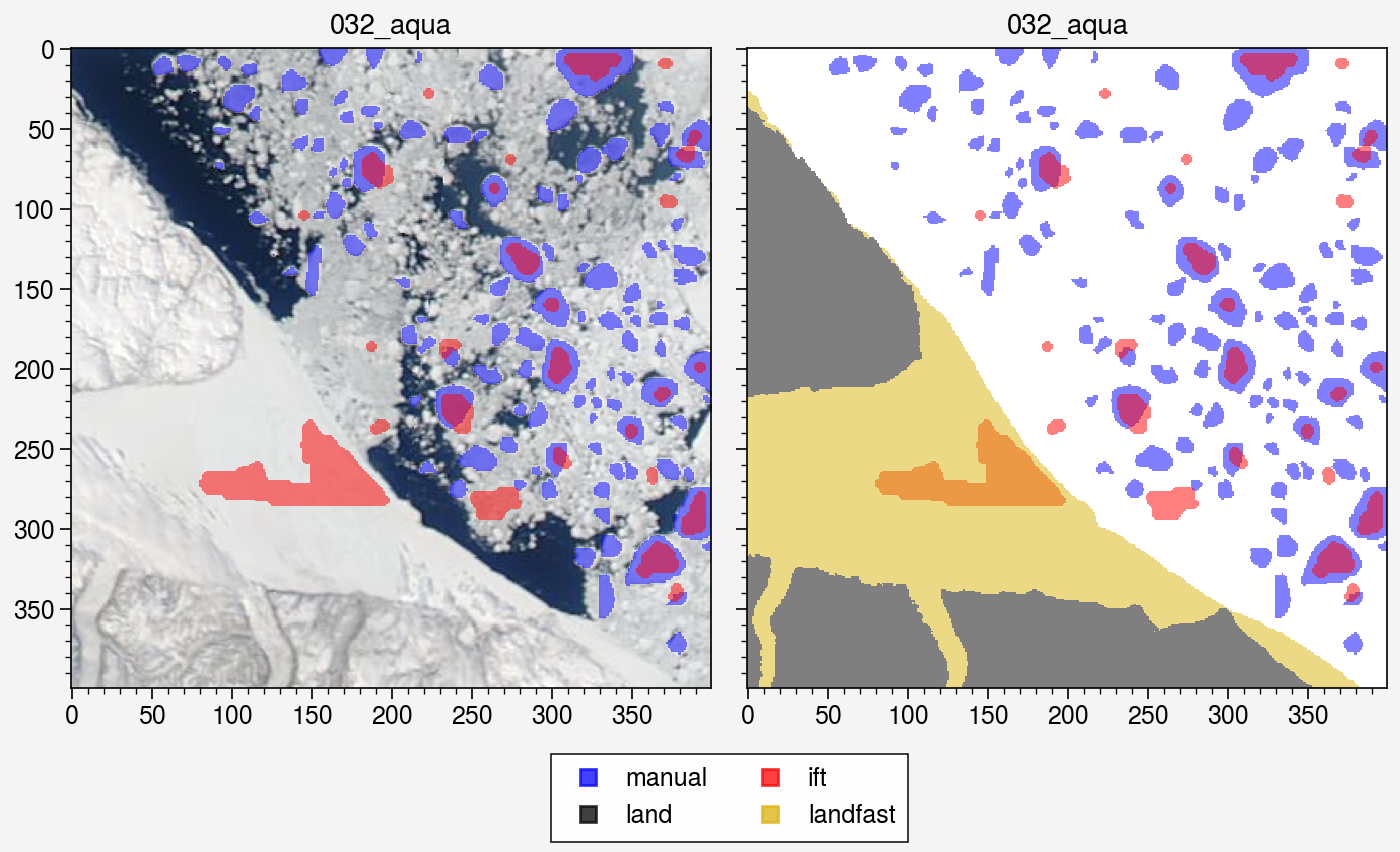

In [187]:
case = '032_aqua'
fig, ax = pplt.subplots(nrows=1, ncols=2, width=7)
ax[0].imshow(reshape_as_image(tc_images[case]))
if case in lb_images:
    manual_floe_labels = np.ma.masked_array(lb_images[case][0,:,:], mask=lb_images[case][0,:,:]==0)
    ax[0].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
    ax[1].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
if case in ift_lb_images:
    ift_floe_labels = np.ma.masked_array(ift_lb_images[case][0,:,:], mask=ift_lb_images[case][0,:,:]==0)
    ax[0].pcolormesh(ift_floe_labels, color='r', alpha=0.5)        
    ax[1].pcolormesh(ift_floe_labels, color='r', alpha=0.5)

try:
    landmask = np.ma.masked_array(landmasks[case][0,:,:], mask=landmasks[case][0,:,:]==0)
    landfast = np.ma.masked_array(landfast_images[case][0,:,:], mask=landfast_images[case][0,:,:]==0)
    if ~np.any(landmask > 0):
        landmask = landmask*0
    
    ax[1].pcolormesh(landmask, color='k', alpha=0.5)
    ax[1].pcolormesh(landfast, color='gold', alpha=0.5)
except:
    print('Couldn\'t plot landmask/landfast for', case)
ax.format(yreverse=True, title=case)

for color, label in zip(['b', 'r', 'k', 'gold'], ['manual', 'ift', 'land', 'landfast']):
    ax[0].plot([],[],m='s', lw=0, color=color, alpha=0.75, label=label)
fig.legend(loc='b', ncols=2, alpha=0.9)


# Adapting the object-based analysis from Simon's code to process this image
- Use scikit-image not cv2, since installation is easier and that's used in IFT already
- Finding the overlaps not too hard. However, need to think how to organize them.
- Pixelwise metrics can be made into score functions in scikit learn if they aren't there already
- Object wise: need to build matches with overlaps.
  - Centroid error
  - Boundary errors: could be difference in perimeter, difference in

0.25919175001264155

In [297]:

[x for x in lb_images.keys() if x in ift_lb_images]

['447_aqua',
 '447_terra',
 '283_aqua',
 '283_terra',
 '110_aqua',
 '110_terra',
 '119_aqua',
 '119_terra',
 '122_aqua',
 '122_terra',
 '132_aqua',
 '142_aqua',
 '142_terra',
 '146_aqua',
 '146_terra',
 '433_aqua',
 '081_terra',
 '301_terra',
 '302_aqua',
 '302_terra',
 '324_aqua',
 '324_terra',
 '325_aqua',
 '325_terra',
 '339_aqua',
 '339_terra',
 '340_terra',
 '385_terra',
 '016_aqua',
 '016_terra',
 '022_aqua',
 '022_terra',
 '023_aqua',
 '023_terra',
 '032_aqua',
 '032_terra']

In [303]:
import skimage
results = []

def distance(p1, p2):
    return np.round(np.sqrt((p1[0] - p2[0])**2 + (p1[0] - p2[1])**2), 2)
    
for case in ['016_aqua', '032_aqua', '022_aqua', '023_aqua']:
    
    man_img = skimage.measure.label(lb_images[case][0,:,:])
    ift_img = ift_lb_images[case][0,:,:] # assumes it's labeled. If not, would need to label it.
    tc_img = tc_images[case]
    land_mask_img = landfast_images[case]
    
    # get the labels from the manual image
    man_img_props = skimage.measure.regionprops(man_img)
    ift_img_props = skimage.measure.regionprops(ift_img)
    man_img_props = {floe.label: floe for floe in man_img_props}
    ift_img_props = {floe.label: floe for floe in ift_img_props}
    # simple true positive: only one IFT label intersects with the manual label and vice versa
    # simple oversegmentation: multiple IFT labels with one manual label
    # simple undersegmentation: single IFT label with multiple manual label
    
    matches = []
    for floe_id in man_img_props:
        # List of IFT floes with nonzero overlap to manual
        ift_matches_manual = np.unique(ift_img[man_img == floe_id])
    
        # List of manual floes with nonzero overlap to the selected IFT floes
        for ift_floe_id in ift_matches_manual:
            if ift_floe_id > 0:
                matches.append([floe_id, ift_floe_id])
    
    match_df = pd.DataFrame(matches, columns=['manual_id', 'ift_id'])
    ift_dupes_df = match_df.loc[match_df.duplicated(subset='ift_id', keep=False)]
    match_df = match_df.loc[~match_df.duplicated(subset='ift_id', keep=False), ]
    
    for row, data in match_df.iterrows():
        underestimate = (man_img == data.manual_id) & (ift_img != data.ift_id)
        overestimate = (man_img != data.manual_id) & (ift_img == data.ift_id)
        a_cap_b = (man_img == data.manual_id) & (ift_img == data.ift_id)
        a_cup_b = (man_img == data.manual_id) | (ift_img == data.ift_id)
    
        match_df.loc[row, 'jaccard_index'] = np.round(np.sum(a_cap_b)/np.sum(a_cup_b), 2)
        match_df.loc[row, 'edge_error'] = np.sum(underestimate | overestimate)
        match_df.loc[row, 'underestimate_error'] = np.sum(underestimate)
        match_df.loc[row, 'overestimate_error'] = np.sum(overestimate)
        match_df.loc[row, 'area'] = np.round(man_img_props[data.manual_id].area, 2)
        match_df.loc[row, 'perimeter'] = np.round(man_img_props[data.manual_id].perimeter, 2)
        match_df.loc[row, 'centeroid_error'] = distance(man_img_props[data.manual_id].centroid, ift_img_props[data.ift_id].centroid)
        match_df.loc[row, 'area_error'] = np.round(ift_img_props[data.ift_id].area - man_img_props[data.manual_id].area, 2)
        match_df.loc[row, 'perimeter_error'] = np.round(ift_img_props[data.ift_id].perimeter - man_img_props[data.manual_id].perimeter, 2)
    results.append(match_df)

In [310]:
pd.DataFrame({'Rel. Edge Error': (match_df['edge_error'])/match_df['area'],
                     'Rel. Ovrst Error': (match_df['overestimate_error'])/match_df['area'],
                     'Rel. Undrst Error': (match_df['underestimate_error'])/match_df['area']})

,Rel. Edge Error,Rel. Ovrst Error,Rel. Undrst Error
0,0.635468,0.000000,0.635468
1,0.681196,0.000251,0.680945
2,0.995908,0.000000,0.995908
3,0.968186,0.000000,0.968186
4,0.995157,0.000000,0.995157
5,0.919422,0.000000,0.919422
6,0.591912,0.000000,0.591912
7,0.671579,0.157895,0.513684
8,0.844538,0.000000,0.844538
9,0.538721,0.000000,0.538721


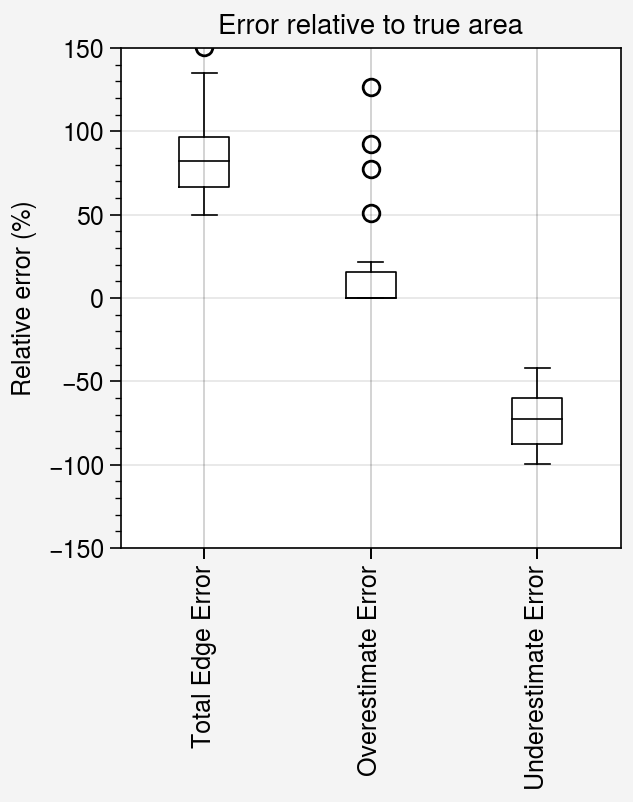

In [316]:
match_df = pd.concat(results).reset_index(drop=True)
fig, ax = pplt.subplots()
ax.box(100*pd.DataFrame({'Total Edge Error': (match_df['edge_error'])/match_df['area'],
                     'Overestimate Error': (match_df['overestimate_error'])/match_df['area'],
                     'Underestimate Error': -(match_df['underestimate_error'])/match_df['area']}))
ax.format(ylim=(-150, 150), title='Error relative to true area', xrotation=90, ylabel='Relative error (%)')

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


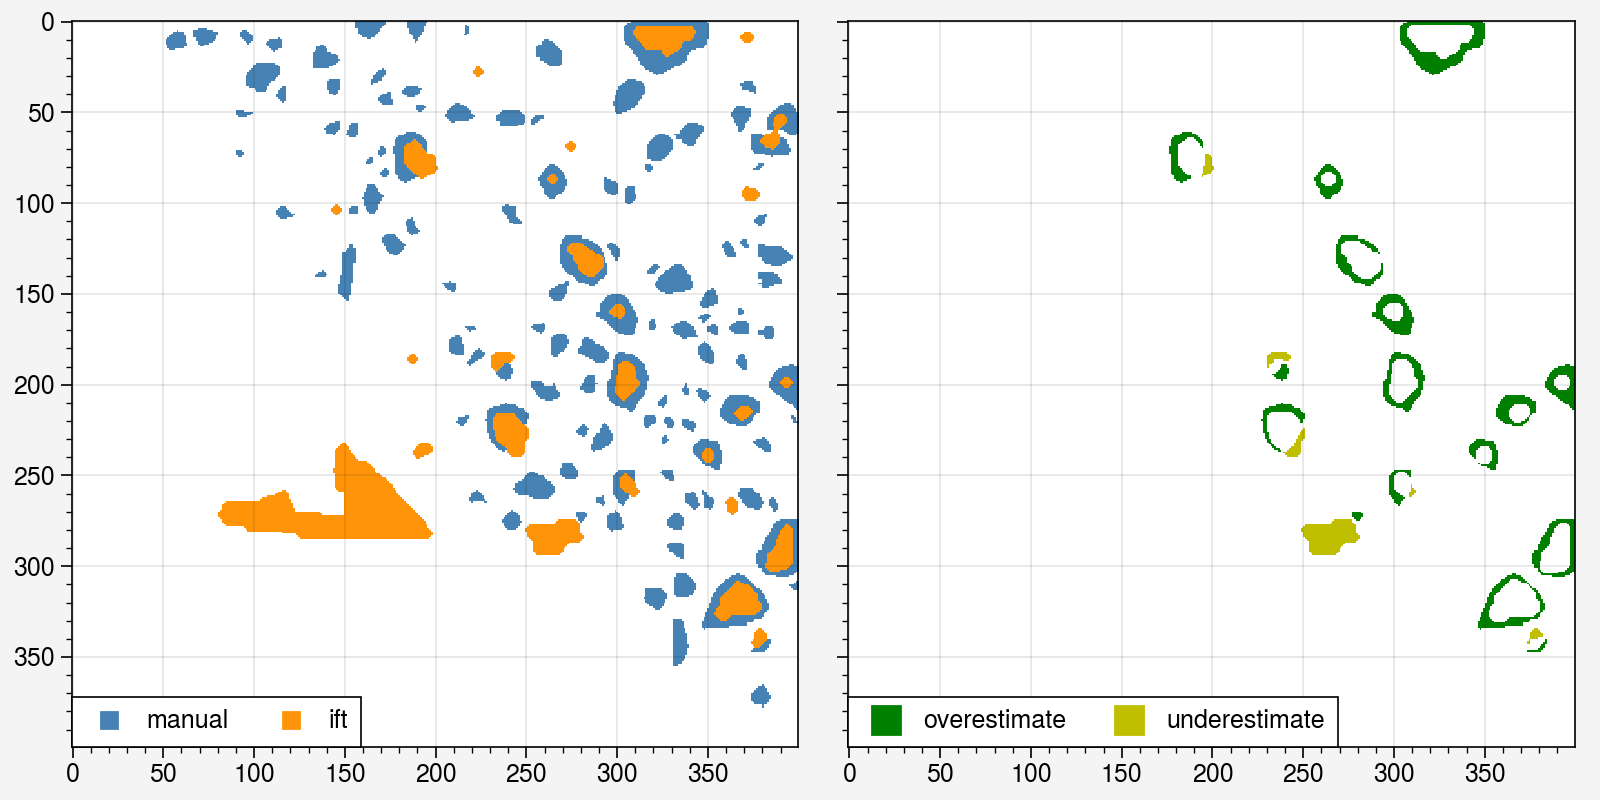

In [275]:
# over/underestimation from Goessling et al. 206 adapted to floe-by-floe
fig, axs = pplt.subplots(width=8, height=4, ncols=2)
axs[0].imshow(np.ma.masked_array(man_img, mask=man_img == 0), color='steelblue', alpha=1)
axs[0].imshow(np.ma.masked_array(ift_img, mask=ift_img == 0), color='tangerine', alpha=1)

for row, data in match_df.iterrows():
    man_floe_id = data.manual_id
    ift_floe_id = data.ift_id
    edge_error = ((man_img == man_floe_id) & (ift_img != ift_floe_id)) | ((man_img != 108) & (ift_img == 24))
    underestimate = (man_img == man_floe_id) & (ift_img != ift_floe_id)
    overestimate = (man_img != man_floe_id) & (ift_img == ift_floe_id)
    axs[1].imshow(np.ma.masked_array(edge_error > 0, mask=~underestimate), color='g', alpha=1)
    axs[1].imshow(np.ma.masked_array(edge_error > 0, mask=~overestimate), color='y', alpha=1)

for color, label in zip(['steelblue', 'tangerine'], ['manual', 'ift']):
    axs[0].plot([],[],m='s', lw=0, color=color, alpha=1, label=label)
axs[0].legend(loc='ll', ncols=2, alpha=1)    
for color, label in zip(['green', 'y'], ['overestimate', 'underestimate']):
    axs[1].plot([],[],m='s', lw=0, color=color, alpha=1, label=label)
axs[1].legend(loc='ll', ncols=2, alpha=1, ms=10)    

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


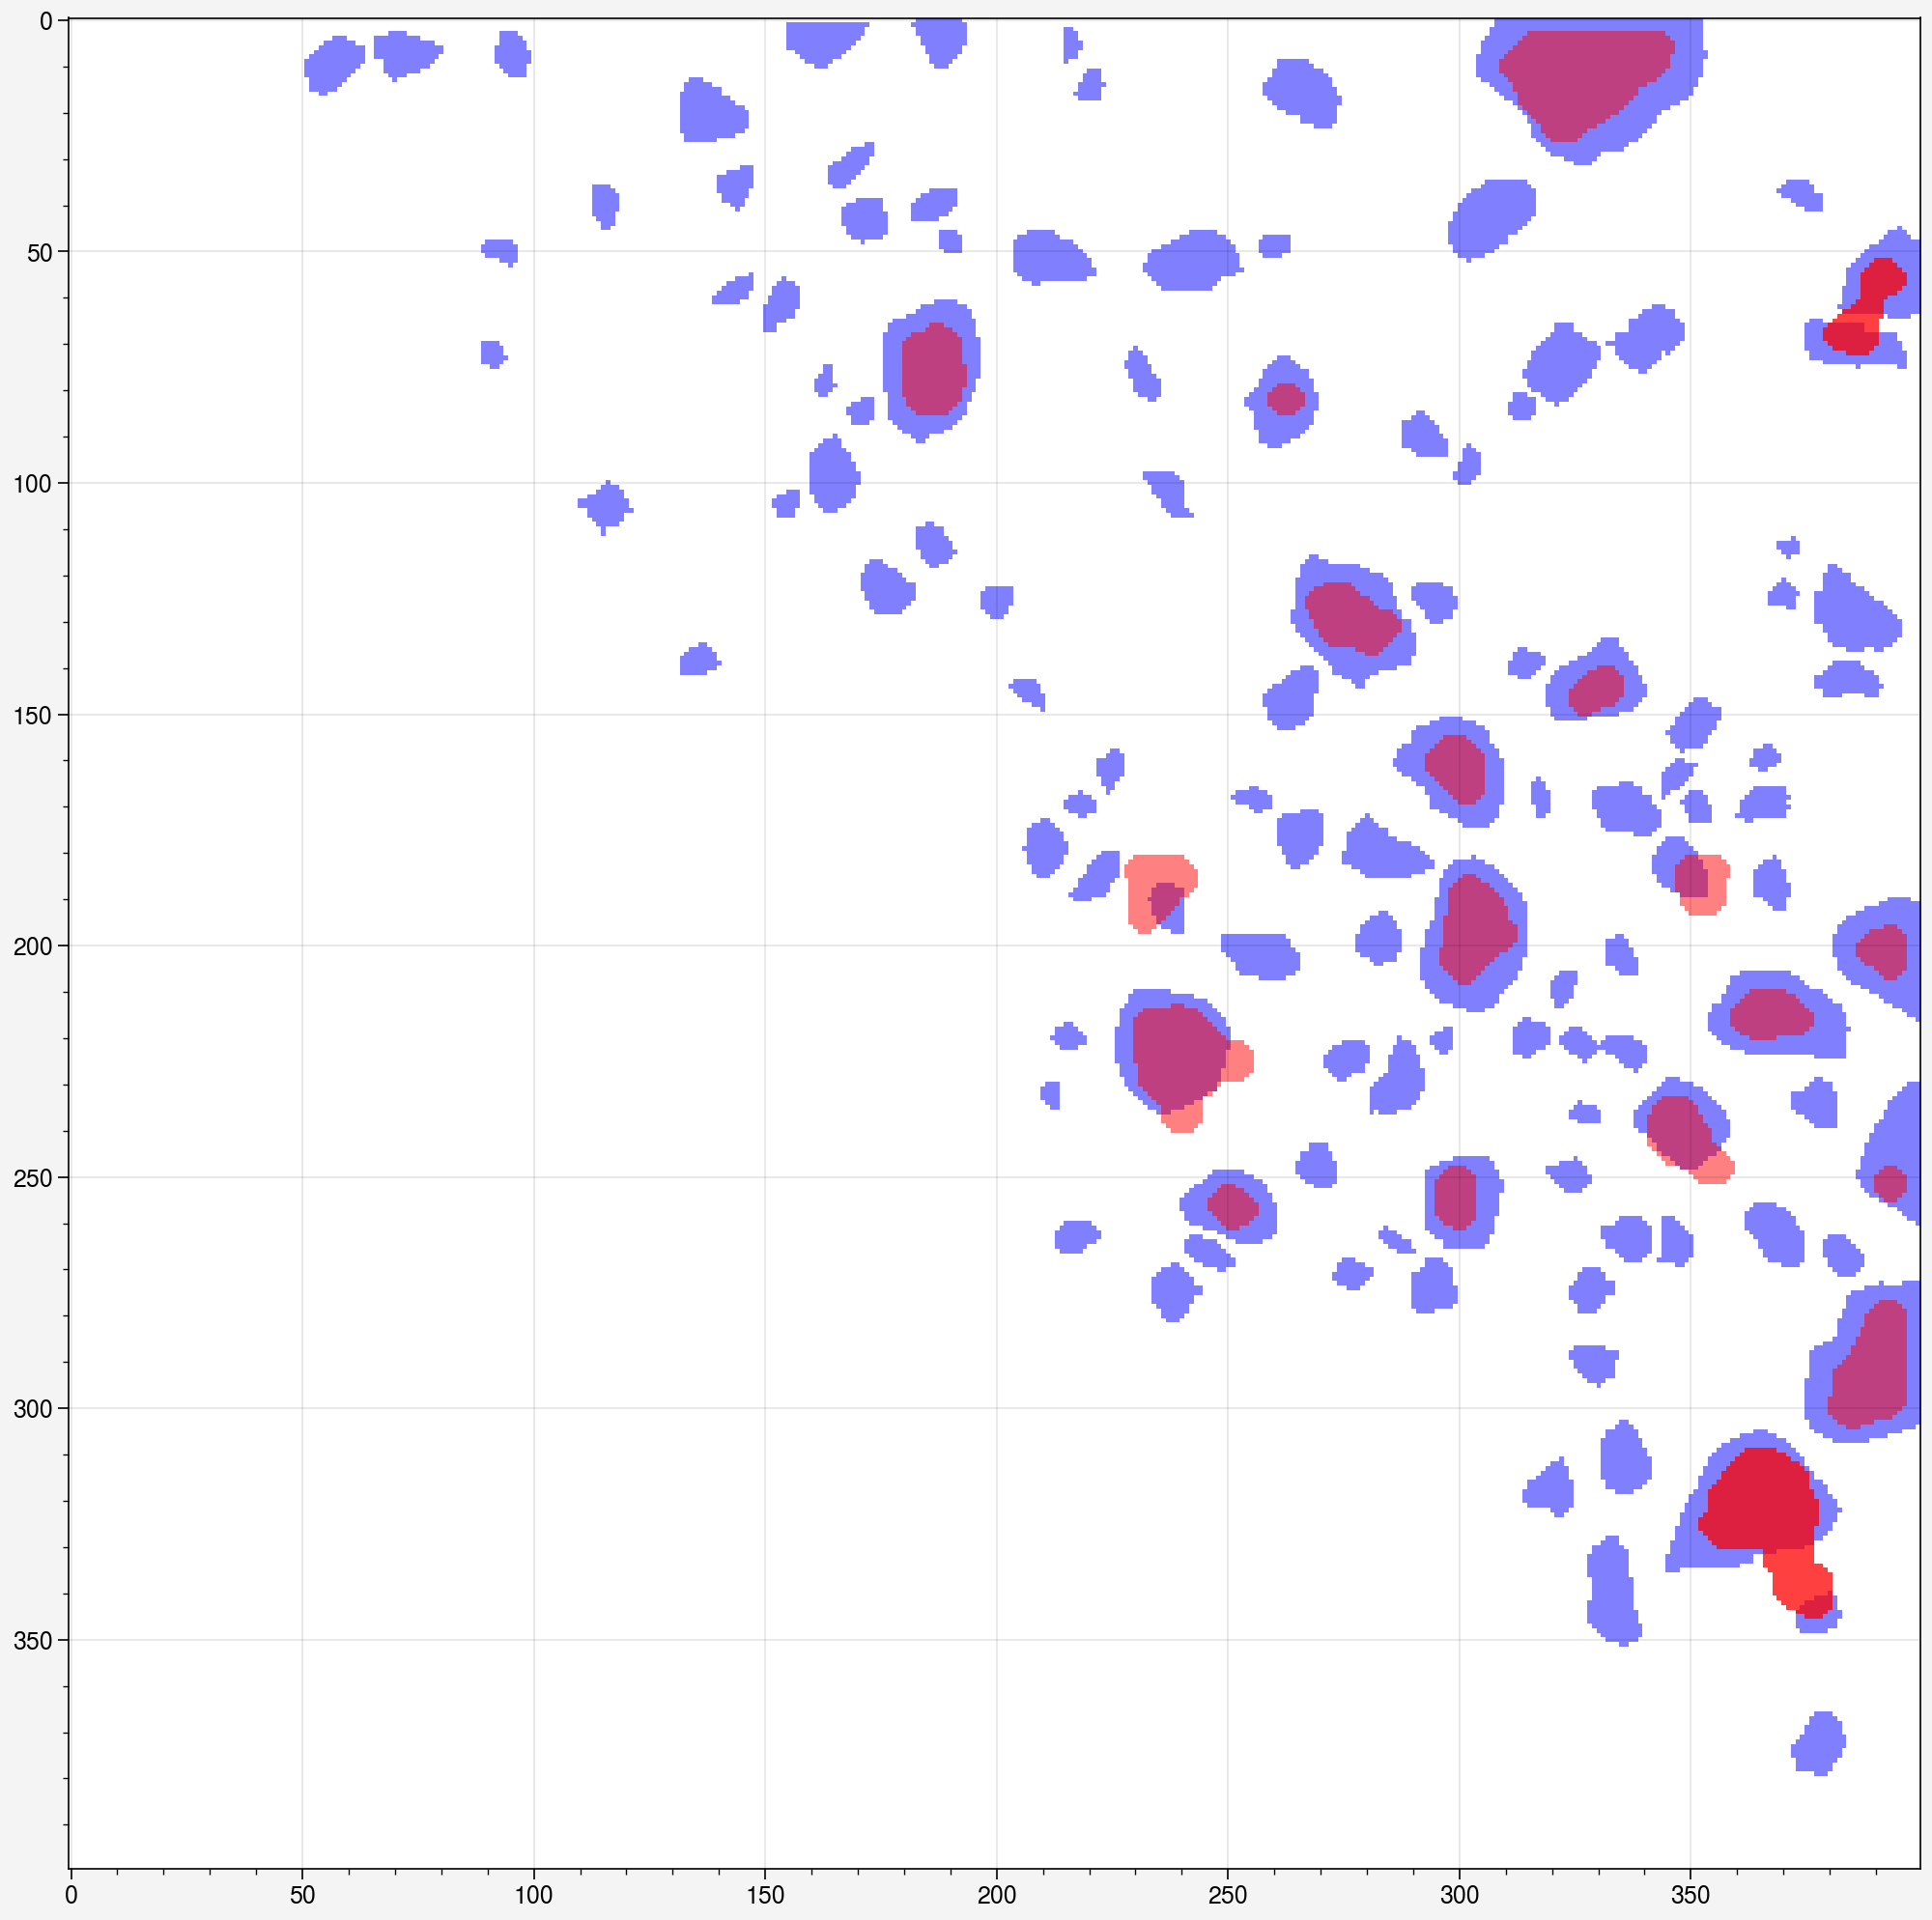

In [191]:
fig, ax = pplt.subplots(width=10)
ax.imshow(np.ma.masked_array(man_img, mask=man_img == 0), color='b', alpha=0.5)
for floe_id in man_img_props:
    
    matches = np.unique(ift_img[man_img == floe_id])
    if np.any(matches > 0):
        if len(matches[matches != 0]) == 1:
            ift_floe_id = matches[matches != 0][0]
            ax.imshow(np.ma.masked_array(ift_img, mask=ift_img != ift_floe_id), color='r', alpha=0.5)

In [157]:
from skimage.metrics import adapted_rand_error, variation_of_information
error, precision, recall = adapted_rand_error(man_img, ift_img)
error, precision, recall

(0.9628331935985566, 0.6345415265067076, 0.019144062864835002)

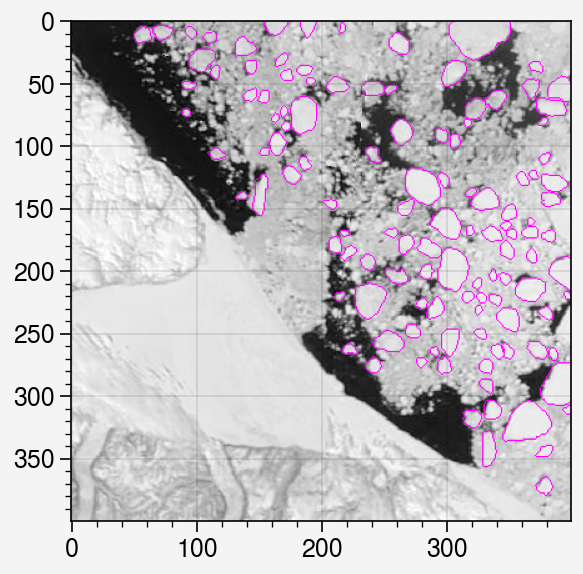

In [155]:
from skimage.segmentation import mark_boundaries
fig, ax = pplt.subplots()
ax.imshow(mark_boundaries(tc_images[case][0,:,:], man_img, color=(1, 0, 1)))

In [ ]:
import cv2
from copy import deepcopy
import numpy as np
import h5py
import sys
from pandas import Series
from filter_function import ift_filter

IOU_THRESHOLD = 0.5

    # Manual image loading
    raw_manual_img = cv2.imread(manual_path)
    manual_img = np.zeros((len(raw_manual_img), len(raw_manual_img[0])))
    idx = raw_manual_img[:,:,0] > 0
    manual_img[idx] = 255

    # Get individual manual floes
    man_num_labels, man_labels, man_stats, man_centroids = cv2.connectedComponentsWithStats(
                                                            manual_img.astype('uint8'), connectivity=8)

    ift_to_manual_floes = {}
    false_positives = []

    # Assume a floe is a false positive until we find an IFT one that corresponds
    false_negatives = list(range(1, man_num_labels))

    # Get IFT overlaps with real floes
    for i in range(1, ift_num_labels):

        # Get indices of points in ift image corresponding to floes
        idx = ift_labels[:,:] == i

        # Check if this floe intersects the landmask
        landmask_intersection = np.logical_and(idx, idx_landmass)

        # If it does, skip this floe for the purposes of calculation
        if np.sum(landmask_intersection) > 0:
            continue

        # Get manual floes in that area.
        manual_area = man_labels[idx]

        # Get the unique numbers of manual floes in that area.
        overlapping_manual = list(set(manual_area))

        # Add to dict based on result
        # If no overlapping real floes, false positive IFT result.
        if len(overlapping_manual) == 1 and overlapping_manual[0] == 0:
            false_positives.append(i)
        
        # Otherwise, add index of real manual floes to dictionary.
        else:
            if 0 in overlapping_manual:
                overlapping_manual.remove(0)
            ift_to_manual_floes[int(i)] = overlapping_manual

            # Remove false negatives
            for floe in overlapping_manual:
                if floe in false_negatives:
                    false_negatives.remove(floe)


    # Can consider the similarity of the floe pairings in the dictionary
    for key, value in ift_to_manual_floes.items():

        # Create list for all real floes matching this predicted floe.
        new_val = []


        # Generate countours of this floe for boundary iou and dilate
        floe_img_idx = ift_labels[:,:] == key
        binary_img = np.zeros_like(floe_img_idx, dtype=np.uint8)
        binary_img[floe_img_idx] = 255
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_img = np.zeros_like(binary_img)
        cv2.drawContours(contour_img, contours, 0, (255))
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
        dilated_predicted_boundary = cv2.dilate(contour_img, kernel, iterations=1)

        dilated_pred_boundary_idx = np.logical_and(dilated_predicted_boundary[:,:] > 0, ift_labels[:,:] != key)
        dilated_predicted_boundary = np.zeros_like(dilated_pred_boundary_idx, dtype=np.uint8)
        dilated_predicted_boundary[dilated_pred_boundary_idx] = 255

        # Get dilated area
        dilated_predicted_area = np.sum(dilated_predicted_boundary[:,:] == 255)
        
        
        for real_floe in value:


            intersection_stats = {}

            intersection_idx = np.logical_and(ift_labels[:,:] == key, man_labels[:,:] == real_floe)

            intersection_area = np.sum(intersection_idx)

            iou = intersection_area / (man_stats[real_floe][4] + ift_stats[key][4] - intersection_area)

            centroid_distance_px = np.sqrt((man_centroids[real_floe][0] - ift_centroids[key][0])**2 + 
                                (man_centroids[real_floe][1] - ift_centroids[key][1])**2)


            # Get dilated real floe boundary
            floe_img_idx = man_labels[:,:] == real_floe
            binary_img = np.zeros_like(floe_img_idx, dtype=np.uint8)
            binary_img[floe_img_idx] = 255
            contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour_img = np.zeros_like(binary_img)
            cv2.drawContours(contour_img, contours, 0, (255))
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
            dilated_real_boundary = cv2.dilate(contour_img, kernel, iterations=1)


            dilated_real_boundary_idx = np.logical_and(dilated_real_boundary[:,:] > 0, man_labels[:,:] == real_floe)
            dilated_real_boundary = np.zeros_like(dilated_real_boundary_idx, dtype=np.uint8)
            dilated_real_boundary[dilated_real_boundary_idx] = 255

            dilated_real_area = np.sum(dilated_real_boundary[:,:] == 255)


            # Calculate boundary iou
            intersection_idx = np.logical_and(dilated_real_boundary[:,:] == 255, dilated_predicted_boundary[:,:] == 255)
            bound_intersection_area = np.sum(intersection_idx)
            boundary_iou = bound_intersection_area / (dilated_real_area + dilated_predicted_area - bound_intersection_area)

            intersection_stats['area_percent_difference'] = (ift_stats[key][4] - man_stats[real_floe][4]) / man_stats[real_floe][4]
            intersection_stats['real_floe'] = int(real_floe)
            intersection_stats['iou'] = iou
            intersection_stats['centroid_distance'] = centroid_distance_px
            intersection_stats['boundary_iou'] = boundary_iou
            new_val.append(intersection_stats)

        ift_to_manual_floes[key] = new_val

    # Copy intersection stats for later
    intersections = deepcopy(ift_to_manual_floes)


    # Non-max suppression
    # Takes care of undersegmentation errors
    for ift, reals in ift_to_manual_floes.items():

        # Gets index of best matching real floe for IFT floe
        possible_match_idx = max(enumerate(reals), key=lambda x: x[1]['iou'])[0]
        
        # Removes best matching from list of IFT floes
        possible_match = reals.pop(possible_match_idx)

        # Adds remainder of floes (besides best match) to false negative list
        for non_match in reals:
            real_floe_number = non_match['real_floe']
            false_negatives.append({'floe_number': real_floe_number, 
                                    'floe_area': int(man_stats[real_floe_number][4]), 
                                    'overlap': True})

        # Sets ift_to_manual key to remaining best match
        ift_to_manual_floes[ift] = possible_match



    # Pair predicted floes to their best predictions
    # Takes care of oversegmentation errors
    to_remove = set()
    for ift1, real1 in ift_to_manual_floes.items():

        for ift2, real2 in ift_to_manual_floes.items():

            if ift1 != ift2 and real1['real_floe'] == real2['real_floe'] and real1['iou'] > real2['iou']:
                to_remove.add(ift2)

    
    for idx in list(to_remove):
        false_positives.append({'floe_number': idx, 
                                    'floe_area': int(ift_stats[idx][4]), 'overlap': True})
        del ift_to_manual_floes[idx]

    """
    After NMS, we have a list of FN and FP floes and a dict with predictions as keys and
    best matching real floes as values. Other real floes have been discarded as FNs.
    After NMS, the next step is determining whether the remaining pairings are good pairings.
    """

    to_remove = []
    for ift, real in ift_to_manual_floes.items():
        if real['boundary_iou'] < IOU_THRESHOLD and real['iou'] < IOU_THRESHOLD:
            to_remove.append(ift)

    for idx in to_remove:
        false_positives.append({'floe_number': idx, 
                                'floe_area': int(ift_stats[idx][4]), 'overlap': True})
        real_floe_number = ift_to_manual_floes[idx]['real_floe']
        false_negatives.append({'floe_number': real_floe_number, 
                                'floe_area': int(man_stats[real_floe_number][4]), 'overlap': True})
        del ift_to_manual_floes[idx]

    # Modify false positives to include floe information
    for i in range(len(false_positives)):
        if isinstance(false_positives[i], dict):
            continue
        else:
            floe_number = false_positives[i]
            floe_dict = {}
            floe_dict['floe_number'] = int(floe_number)
            floe_dict['floe_area'] = int(ift_stats[floe_number][4])
            floe_dict['overlap'] = False
            false_positives[i] = floe_dict

        
    # Modify false negatives to include floe information
    for i in range(len(false_negatives)):
        if isinstance(false_negatives[i], dict):
            continue
        else:
            floe_number = false_negatives[i]
            floe_dict = {}
            floe_dict['floe_number'] = int(floe_number)
            floe_dict['floe_area'] = int(man_stats[floe_number][4])
            floe_dict['overlap'] = False
            false_negatives[i] = floe_dict

    floe_conf_matrix = {'t_pos_floes': len(ift_to_manual_floes), 'f_pos_floes': len(false_positives), 
                        'f_neg_floes': len(false_negatives), 't_neg_floes': 1}


    ift_to_manual_tp = {}
    for k, v in ift_to_manual_floes.items():
        ift_to_manual_tp[k] = {'real_floe': v['real_floe'], 'real_floe_area': int(man_stats[v['real_floe']][4]),
                                'ift_floe_area': int(ift_stats[k][4])}

    if threshold_params:
        props['TP'] = ''
        props['ift_path'] = ift_path

        for open, labeled in open_to_labeled_map.items():
            props.loc[props['label'] == labeled, 'TP'] = (open in ift_to_manual_tp.keys())

    return floe_conf_matrix, false_positives, false_negatives, ift_to_manual_tp, intersections, labeled_image, props